### RNN From Scratch

**Soban Nasir Lone** \
*2022AMY7554*

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

Default settings : \
25 epochs \
No Tanh at output 
\
Weights clipped to prevent exploding gradients

In [2]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1),np.array(y).reshape(len(y),1)

class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2]) # shape (hidden units, number of input features)
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)
    
    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.dot(self.Wy,ht)
        return ht, yt
        
    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units,1)) # first hidden state is zeros vector
        self.hidden_states = [ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step],ht)
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
        self.error = yt - sample_y
        self.loss = 0.5*self.error**2
        self.yt = yt

    
    def backward(self):
        n = len(self.inputs)
        dyt = self.error # dL/dyt
        dWy = np.dot(dyt,self.hidden_states[-1].T) # dyt/dWy
        dht = np.dot(dyt, self.Wy).T # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)
        # BPTT
        for step in reversed(range(n)):
            temp = (1-self.hidden_states[step+1]**2) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2) 
            dWx += np.dot(temp, self.inputs[step].T) # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh += np.dot(temp, self.hidden_states[step].T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

            dht = np.dot(self.Wh, temp) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            if epoch%5==0:
                print("Epoch : ", epoch, "Loss: ", np.mean(self.Ovr_loss))
            self.loss = 0
            
        
        
    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)
        
x,y = dataset()
x_test, y_test = dataset(300)
x_test = x_test[250:]
y_test = y_test[250:]
rnn = RNN(x,y,100)
rnn.train(25,1e-2)
rnn.test(x_test, y_test)

  4%|▍         | 1/25 [00:01<00:42,  1.78s/it]

Epoch :  0 Loss:  0.046955796889675015


 24%|██▍       | 6/25 [00:10<00:34,  1.81s/it]

Epoch :  5 Loss:  0.021741035019208422


 44%|████▍     | 11/25 [00:18<00:23,  1.65s/it]

Epoch :  10 Loss:  0.012265420382015956


 64%|██████▍   | 16/25 [00:28<00:16,  1.83s/it]

Epoch :  15 Loss:  0.009170342758411894


 84%|████████▍ | 21/25 [00:36<00:06,  1.69s/it]

Epoch :  20 Loss:  0.007047808154258564


100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


Text(0, 0.5, 'Target vs Predicted')

<Figure size 640x480 with 0 Axes>

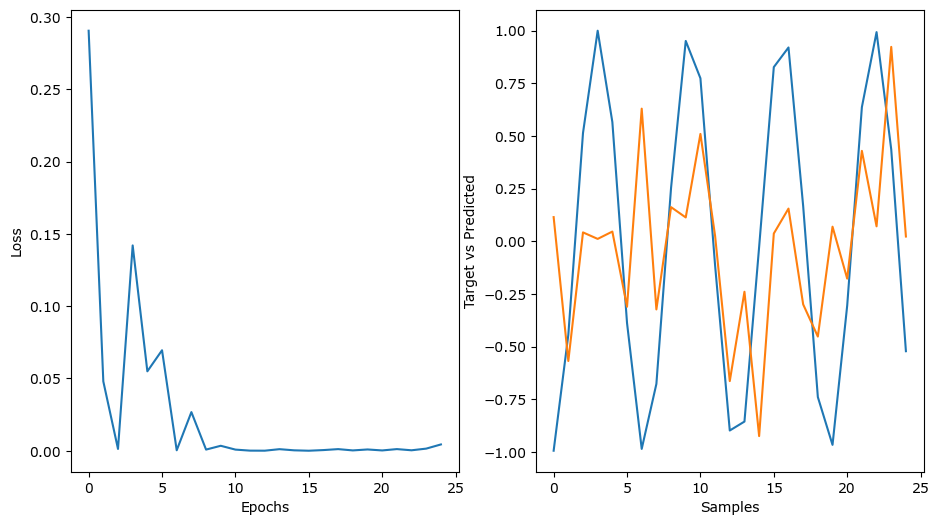

In [4]:
plt.tight_layout()
plt.figure(figsize = (11,6))
plt.subplot(121)
plt.plot(rnn.Ovr_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot([i for i in range(len(x_test))], y_test, np.array(rnn.outputs).reshape(y_test.shape))
plt.xlabel('Samples')
plt.ylabel('Target vs Predicted')


Using Tanh at output \
Weights clipped to be between -1 to 1

In [6]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1),np.array(y).reshape(len(y),1)

class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2]) # shape (hidden units, number of input features)
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)
    
    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.tanh(np.dot(self.Wy,ht))
        return ht, yt
        
    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units,1)) # first hidden state is zeros vector
        self.hidden_states = [ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step],ht)
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
        self.error = yt - sample_y
        self.loss = 0.5*self.error**2
        self.yt = yt

    
    def backward(self):
        n = len(self.inputs)
        dyt = self.error # dL/dyt
        dWy = np.dot(dyt,self.hidden_states[-1].T) # dyt/dWy
        dht = np.dot(dyt, self.Wy).T # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)
        # BPTT
        for step in reversed(range(n)):
            temp = (1-self.hidden_states[step+1]**2) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2) 
            dWx += np.dot(temp, self.inputs[step].T) # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh += np.dot(temp, self.hidden_states[step].T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

            dht = np.dot(self.Wh, temp) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            if epoch%5==0:
                print("Epoch : ", epoch, "Loss: ", np.mean(self.Ovr_loss))
            self.loss = 0
            
        
        
    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)
        
x,y = dataset()
x_test, y_test = dataset(300)
x_test = x_test[250:]
y_test = y_test[250:]
rnn = RNN(x,y,100)
rnn.train(25,1e-2)
rnn.test(x_test, y_test)

  4%|▍         | 1/25 [00:01<00:35,  1.48s/it]

Epoch :  0 Loss:  3.96984319755935e-05


 24%|██▍       | 6/25 [00:08<00:24,  1.29s/it]

Epoch :  5 Loss:  0.003387495882735252


 44%|████▍     | 11/25 [00:15<00:20,  1.45s/it]

Epoch :  10 Loss:  0.0027535272559018665


 64%|██████▍   | 16/25 [00:21<00:10,  1.19s/it]

Epoch :  15 Loss:  0.0027495015075393674


 84%|████████▍ | 21/25 [00:26<00:04,  1.03s/it]

Epoch :  20 Loss:  0.002156719537988382


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


Text(0, 0.5, 'Target vs Predicted')

<Figure size 640x480 with 0 Axes>

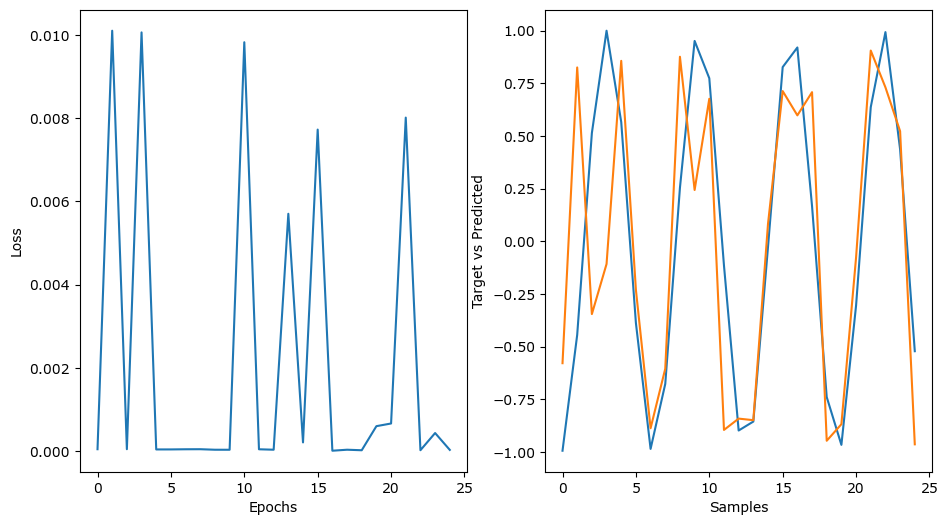

In [7]:
plt.tight_layout()
plt.figure(figsize = (11,6))
plt.subplot(121)
plt.plot(rnn.Ovr_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot([i for i in range(len(x_test))], y_test, np.array(rnn.outputs).reshape(y_test.shape))
plt.xlabel('Samples')
plt.ylabel('Target vs Predicted')


As we can see, the loss does not decrease monotonically. There are many spikes in between epochs.

**Without Clipping and Without tanh at output**

In [5]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1),np.array(y).reshape(len(y),1)

class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2]) # shape (hidden units, number of input features)
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)
    
    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.dot(self.Wy,ht)
        return ht, yt
        
    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units,1)) # first hidden state is zeros vector
        self.hidden_states = [ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step],ht)
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
        self.error = yt - sample_y
        self.loss = 0.5*self.error**2
        self.yt = yt

    
    def backward(self):
        n = len(self.inputs)
        dyt = self.error # dL/dyt
        dWy = np.dot(dyt,self.hidden_states[-1].T) # dyt/dWy
        dht = np.dot(dyt, self.Wy).T # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)
        # BPTT
        for step in reversed(range(n)):
            temp = (1-self.hidden_states[step+1]**2) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2) 
            dWx += np.dot(temp, self.inputs[step].T) # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh += np.dot(temp, self.hidden_states[step].T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

            dht = np.dot(self.Wh, temp) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh
#No Clipping:
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            if epoch%5==0:
                print("Epoch: ", epoch,"Loss: " ,np.mean(self.Ovr_loss))
            self.loss = 0
            
        
        
    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)
        
x,y = dataset()
x_test, y_test = dataset(300)
x_test = x_test[250:]
y_test = y_test[250:]
rnn = RNN(x,y,100)
rnn.train(25,1e-2)
rnn.test(x_test, y_test)

  4%|▍         | 1/25 [00:00<00:19,  1.24it/s]

Epoch:  0 Loss:  0.03758331802551385


 24%|██▍       | 6/25 [00:04<00:14,  1.34it/s]

Epoch:  5 Loss:  0.02451065939112101


 44%|████▍     | 11/25 [00:08<00:10,  1.36it/s]

Epoch:  10 Loss:  0.014632922310794343


 64%|██████▍   | 16/25 [00:11<00:06,  1.37it/s]

Epoch:  15 Loss:  0.010178766885350948


 84%|████████▍ | 21/25 [00:16<00:03,  1.16it/s]

Epoch:  20 Loss:  0.0077792393875332055


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


Text(0, 0.5, 'Target vs Predicted')

<Figure size 640x480 with 0 Axes>

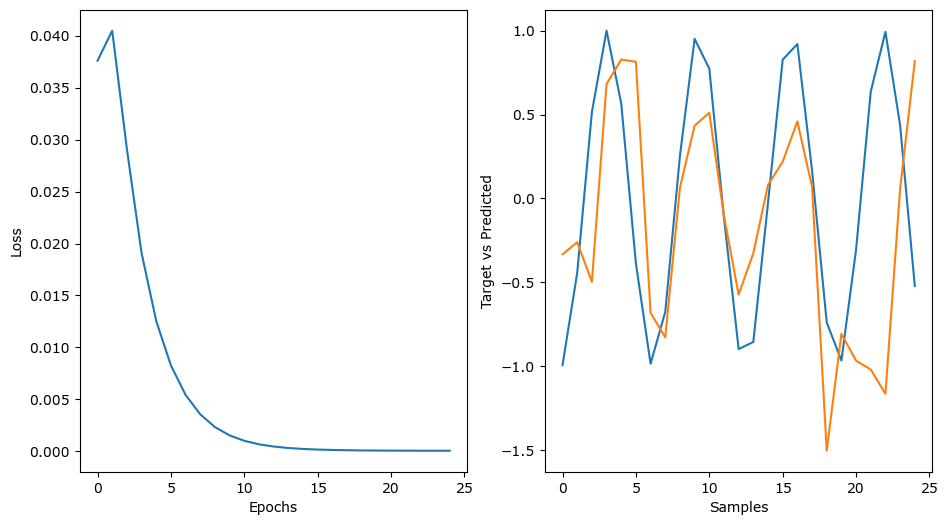

In [6]:
plt.tight_layout()
plt.figure(figsize = (11,6))
plt.subplot(121)
plt.plot(rnn.Ovr_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot([i for i in range(len(x_test))], y_test, np.array(rnn.outputs).reshape(y_test.shape))
plt.xlabel('Samples')
plt.ylabel('Target vs Predicted')


Graidents seem to be exploding and the predictions are off

**Without Clipping, with Tanh**

In [7]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1),np.array(y).reshape(len(y),1)

class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2]) # shape (hidden units, number of input features)
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)
    
    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.tanh(np.dot(self.Wy,ht))
        return ht, yt
        
    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units,1)) # first hidden state is zeros vector
        self.hidden_states = [ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step],ht)
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
        self.error = yt - sample_y
        self.loss = 0.5*self.error**2
        self.yt = yt

    
    def backward(self):
        n = len(self.inputs)
        dyt = self.error # dL/dyt
        dWy = np.dot(dyt,self.hidden_states[-1].T) # dyt/dWy
        dht = np.dot(dyt, self.Wy).T # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)
        # BPTT
        for step in reversed(range(n)):
            temp = (1-self.hidden_states[step+1]**2) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2) 
            dWx += np.dot(temp, self.inputs[step].T) # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh += np.dot(temp, self.hidden_states[step].T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

            dht = np.dot(self.Wh, temp) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh
#No Clipping:
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            if epoch%5==0:
                print("Epoch: ", epoch,"Loss: " ,np.mean(self.Ovr_loss))
            self.loss = 0
            
        
        
    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)
        
x,y = dataset()
x_test, y_test = dataset(300)
x_test = x_test[250:]
y_test = y_test[250:]
rnn = RNN(x,y,100)
rnn.train(25,1e-2)
rnn.test(x_test, y_test)

  4%|▍         | 1/25 [00:00<00:17,  1.35it/s]

Epoch:  0 Loss:  3.991414500690183e-05


 24%|██▍       | 6/25 [00:04<00:14,  1.35it/s]

Epoch:  5 Loss:  3.991756388671743e-05


 44%|████▍     | 11/25 [00:08<00:10,  1.32it/s]

Epoch:  10 Loss:  3.9917731783998236e-05


 64%|██████▍   | 16/25 [00:13<00:07,  1.16it/s]

Epoch:  15 Loss:  3.991753728961429e-05


 84%|████████▍ | 21/25 [00:18<00:04,  1.00s/it]

Epoch:  20 Loss:  3.9916687840184674e-05


100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Text(0, 0.5, 'Target vs Predicted')

<Figure size 640x480 with 0 Axes>

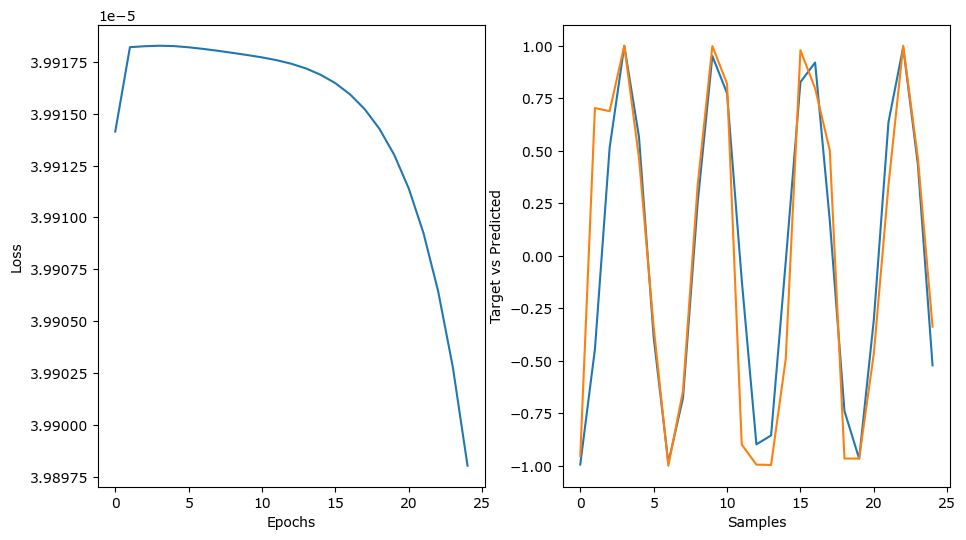

In [8]:
plt.tight_layout()
plt.figure(figsize = (11,6))
plt.subplot(121)
plt.plot(rnn.Ovr_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot([i for i in range(len(x_test))], y_test, np.array(rnn.outputs).reshape(y_test.shape))
plt.xlabel('Samples')
plt.ylabel('Target vs Predicted')


Since we're using Tanh output, the gradients are somewhat stopped from getting exploded but the predictions are still a little off.

**Default Setting but with 100 epochs:**

In [9]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1),np.array(y).reshape(len(y),1)

class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2]) # shape (hidden units, number of input features)
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)
    
    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.dot(self.Wy,ht)
        return ht, yt
        
    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units,1)) # first hidden state is zeros vector
        self.hidden_states = [ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step],ht)
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
        self.error = yt - sample_y
        self.loss = 0.5*self.error**2
        self.yt = yt

    
    def backward(self):
        n = len(self.inputs)
        dyt = self.error # dL/dyt
        dWy = np.dot(dyt,self.hidden_states[-1].T) # dyt/dWy
        dht = np.dot(dyt, self.Wy).T # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)
        # BPTT
        for step in reversed(range(n)):
            temp = (1-self.hidden_states[step+1]**2) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2) 
            dWx += np.dot(temp, self.inputs[step].T) # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh += np.dot(temp, self.hidden_states[step].T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

            dht = np.dot(self.Wh, temp) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            if epoch%5==0:
                print("Epoch : ", epoch, "Loss: ", np.mean(self.Ovr_loss))
            self.loss = 0
            
        
        
    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)
        
x,y = dataset()
x_test, y_test = dataset(300)
x_test = x_test[250:]
y_test = y_test[250:]
rnn = RNN(x,y,100)
rnn.train(100,1e-2)
rnn.test(x_test, y_test)

  1%|          | 1/100 [00:00<01:14,  1.32it/s]

Epoch :  0 Loss:  0.12442747886853957


  6%|▌         | 6/100 [00:04<01:12,  1.30it/s]

Epoch :  5 Loss:  0.059737835337965284


 11%|█         | 11/100 [00:09<01:16,  1.17it/s]

Epoch :  10 Loss:  0.033007443116756734


 16%|█▌        | 16/100 [00:13<01:04,  1.31it/s]

Epoch :  15 Loss:  0.022838461830269496


 21%|██        | 21/100 [00:17<00:59,  1.33it/s]

Epoch :  20 Loss:  0.017857459897819814


 26%|██▌       | 26/100 [00:22<01:18,  1.06s/it]

Epoch :  25 Loss:  0.014747402254012758


 31%|███       | 31/100 [00:27<01:15,  1.09s/it]

Epoch :  30 Loss:  0.012492192775608247


 36%|███▌      | 36/100 [00:32<01:07,  1.06s/it]

Epoch :  35 Loss:  0.010921494869627561


 41%|████      | 41/100 [00:38<01:15,  1.28s/it]

Epoch :  40 Loss:  0.009800174636048953


 46%|████▌     | 46/100 [00:42<00:48,  1.12it/s]

Epoch :  45 Loss:  0.008914474126776485


 51%|█████     | 51/100 [00:47<00:45,  1.08it/s]

Epoch :  50 Loss:  0.008128800878452814


 56%|█████▌    | 56/100 [00:53<00:48,  1.11s/it]

Epoch :  55 Loss:  0.007409124574790979


 61%|██████    | 61/100 [00:59<00:42,  1.09s/it]

Epoch :  60 Loss:  0.0068031551953172354


 66%|██████▌   | 66/100 [01:05<00:42,  1.25s/it]

Epoch :  65 Loss:  0.0062939048159387015


 71%|███████   | 71/100 [01:11<00:37,  1.30s/it]

Epoch :  70 Loss:  0.005858053415724449


 76%|███████▌  | 76/100 [01:16<00:28,  1.18s/it]

Epoch :  75 Loss:  0.005479719433139489


 81%|████████  | 81/100 [01:20<00:16,  1.15it/s]

Epoch :  80 Loss:  0.0051470627751472485


 86%|████████▌ | 86/100 [01:26<00:13,  1.01it/s]

Epoch :  85 Loss:  0.00485219660751204


 91%|█████████ | 91/100 [01:31<00:08,  1.02it/s]

Epoch :  90 Loss:  0.004589178144483951


 96%|█████████▌| 96/100 [01:37<00:04,  1.15s/it]

Epoch :  95 Loss:  0.004353014657552739


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


Text(0, 0.5, 'Target vs Predicted')

<Figure size 640x480 with 0 Axes>

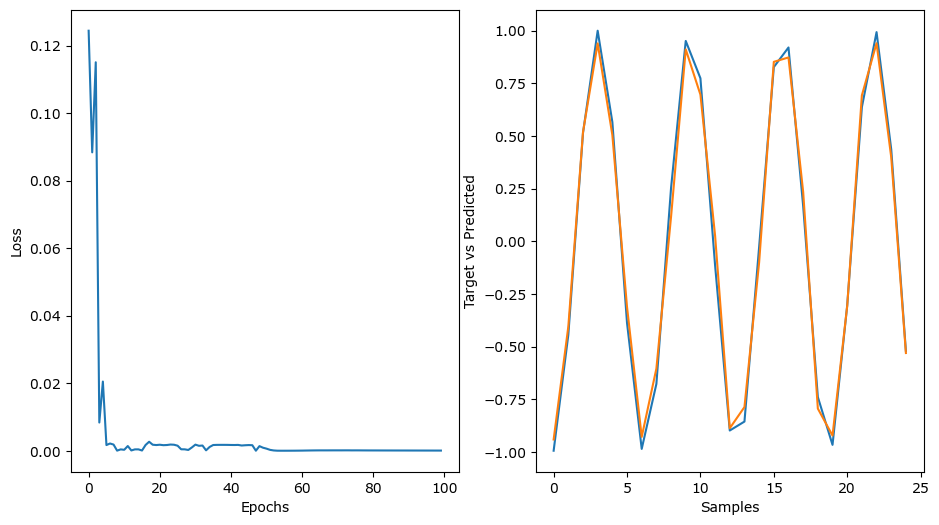

In [10]:
plt.tight_layout()
plt.figure(figsize = (11,6))
plt.subplot(121)
plt.plot(rnn.Ovr_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot([i for i in range(len(x_test))], y_test, np.array(rnn.outputs).reshape(y_test.shape))
plt.xlabel('Samples')
plt.ylabel('Target vs Predicted')


If we train for larger number of epochs, loss seems to be decreasing and the predictions are fine as well.